#:ทดสอบเชื่อมต่อ **Feedforward Backpropagation** และใช้Activation function รวมกับ Optimizer และ L1-L2 regularization
#วันที่ 18/07/2023
# ฝึกทำโดย ***หยางคุณ***

In [28]:
import numpy as np

class FFBP:
    def __init__(self, learning_rate=0.001, num_epochs=30, batch_size=64, hidden_units=256, l1=0.0, l2=0.0):
        # Convert target variable to one-hot encoding ค่าตัวแปรเป้าหมายที่เป็นหมายเลขหรือประเภทหนึ่งให้เป็นรหัสแบบทวิตแบบเวกเตอร์
        self.num_classes = 10

        # กำหนดค่าและปรับเพื่อปรับปรุงประสิทธิภาพของการเรียนรู้ของระบบ  Set hyperparameters
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.hidden_units = hidden_units
        self.l1 = l1
        self.l2 = l2
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # กำหนดค่าเริ่มต้น Initialize weights and biases
        np.random.seed(0)
        self.W1 = None #จุดนี้แสดงให้เห็นว่าตัวแปรถูกกำหนดค่าเริ่มต้นเป็น None ซึ่งหมายถึงว่ายังไม่มีค่าใดๆ ให้กับตัวแปรนี้
        self.b1 = None
        self.W2 = None
        self.b2 = None

        # กำหนดค่าเริ่มต้น Initialize Adam parameters
        self.mW1 = None #จุดนี้แสดงให้เห็นว่าตัวแปรถูกกำหนดค่าเริ่มต้นเป็น None ซึ่งหมายถึงว่ายังไม่มีค่าใดๆ ให้กับตัวแปรนี้
        self.mb1 = None
        self.mW2 = None
        self.mb2 = None
        self.vW1 = None
        self.vb1 = None
        self.vW2 = None
        self.vb2 = None

        self.loss = []

    # Activation function
    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    # function ที่ปรับค่า weights and biases Optimizer parameters
    def adam(self):
        self.mW2 = self.beta1 * self.mW2 + (1 - self.beta1) * self.grad_W2
        self.mb2 = self.beta1 * self.mb2 + (1 - self.beta1) * self.grad_b2
        self.mW1 = self.beta1 * self.mW1 + (1 - self.beta1) * self.grad_W1
        self.mb1 = self.beta1 * self.mb1 + (1 - self.beta1) * self.grad_b1

        self.vW2 = self.beta2 * self.vW2 + (1 - self.beta2) * np.square(self.grad_W2)
        self.vb2 = self.beta2 * self.vb2 + (1 - self.beta2) * np.square(self.grad_b2)
        self.vW1 = self.beta2 * self.vW1 + (1 - self.beta2) * np.square(self.grad_W1)
        self.vb1 = self.beta2 * self.vb1 + (1 - self.beta2) * np.square(self.grad_b1)

        mW2_hat = self.mW2 / (1 - self.beta1 ** (self.epoch + 1))
        mb2_hat = self.mb2 / (1 - self.beta1 ** (self.epoch + 1))
        mW1_hat = self.mW1 / (1 - self.beta1 ** (self.epoch + 1))
        mb1_hat = self.mb1 / (1 - self.beta1 ** (self.epoch + 1))

        vW2_hat = self.vW2 / (1 - self.beta2 ** (self.epoch + 1))
        vb2_hat = self.vb2 / (1 - self.beta2 ** (self.epoch + 1))
        vW1_hat = self.vW1 / (1 - self.beta2 ** (self.epoch + 1))
        vb1_hat = self.vb1 / (1 - self.beta2 ** (self.epoch + 1))

        self.W2 -= self.learning_rate * mW2_hat / (np.sqrt(vW2_hat) + self.epsilon)
        self.b2 -= self.learning_rate * mb2_hat / (np.sqrt(vb2_hat) + self.epsilon)
        self.W1 -= self.learning_rate * mW1_hat / (np.sqrt(vW1_hat) + self.epsilon)
        self.b1 -= self.learning_rate * mb1_hat / (np.sqrt(vb1_hat) + self.epsilon)

    def rmsprop(self):
        self.vW2 = self.beta1 * self.vW2 + (1 - self.beta1) * np.square(self.grad_W2)
        self.vb2 = self.beta1 * self.vb2 + (1 - self.beta1) * np.square(self.grad_b2)
        self.vW1 = self.beta1 * self.vW1 + (1 - self.beta1) * np.square(self.grad_W1)
        self.vb1 = self.beta1 * self.vb1 + (1 - self.beta1) * np.square(self.grad_b1)

        self.W2 -= self.learning_rate * self.grad_W2 / (np.sqrt(self.vW2) + self.epsilon)
        self.b2 -= self.learning_rate * self.grad_b2 / (np.sqrt(self.vb2) + self.epsilon)
        self.W1 -= self.learning_rate * self.grad_W1 / (np.sqrt(self.vW1) + self.epsilon)
        self.b1 -= self.learning_rate * self.grad_b1 / (np.sqrt(self.vb1) + self.epsilon)


    # fit เป็นเมธอดที่ใช้ในการฝึก (train) โมเดลเครื่องมือการเรียนรู้ (machine learning)
    def fit(self, X_train, y_train, X_test, y_test, adam=False, rmsprop=False):
        self.num_classes = np.max(y_train) + 1
        self.y_train_encoded = np.eye(self.num_classes)[y_train]

        # กำหนดค่าในการเริ้มปับค่า Initialize weights and biases
        input_size = X_train.shape[1]
        output_size = self.num_classes
        self.W1 = np.random.randn(input_size, self.hidden_units)
        self.b1 = np.zeros(self.hidden_units)
        self.W2 = np.random.randn(self.hidden_units, output_size)
        self.b2 = np.zeros(output_size)

        # กำหนดค่าในการเริ่มปรับแต่งค่า Initialize Adam parameters
        self.mW1 = np.zeros_like(self.W1) # คือการสร้างตัวแปร mW1 ที่มีค่าเป็นศูนย์ (zeros) และมีขนาดเท่ากับตัวแปร W1 โดยใช้ฟังก์ชัน np.zeros_like() ในการสร้างตัวแปรใหม่ที่มีค่าเป็นศูนย์และมีขนาดเท่ากับตัวแปรที่กำหนดให้เป็นพารามิเตอร์
        self.mb1 = np.zeros_like(self.b1) # คือการสร้างตัวแปร mฺb1 ที่มีค่าเป็นศูนย์ (zeros) และมีขนาดเท่ากับตัวแปร b1 โดยใช้ฟังก์ชัน np.zeros_like() ในการสร้างตัวแปรใหม่ที่มีค่าเป็นศูนย์และมีขนาดเท่ากับตัวแปรที่กำหนดให้เป็นพารามิเตอร์
        self.mW2 = np.zeros_like(self.W2)
        self.mb2 = np.zeros_like(self.b2)
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)

        # ลูปในการ Training loop
        for epoch in range(self.num_epochs):
            # Shuffle the data การ Shuffle ข้อมูลหมายถึงกระบวนการสลับลำดับข้อมูลในชุดข้อมูล
            indices = np.random.permutation(X_train.shape[0])
            X_train = X_train[indices]
            self.y_train_encoded = self.y_train_encoded[indices]

            # Mini-batch gradient descent คือแนวคิดในการอัปเดตพารามิเตอร์ของโมเดลในขั้นตอนการฝึก (training) โดยแบ่งชุดข้อมูลฝึกออกเป็นส่วนย่อยๆ
            num_batches = X_train.shape[0] // self.batch_size
            for batch in range(num_batches):
                # Extract mini-batch หมายถึงกระบวนการสกัดชุดข้อมูลย่อย (mini-batch) จากชุดข้อมูลทั้งหมด เพื่อนำไปใช้ในกระบวนการฝึกโมเดล
                start = batch * self.batch_size
                end = start + self.batch_size
                X_batch = X_train[start:end]
                y_batch = self.y_train_encoded[start:end]

                # Forward propagation หมายถึงกระบวนการทำนายผลลัพธ์ของโมเดลจากข้อมูลนำเข้า (input) ไปยังข้อมูลผลลัพธ์ (output) โดยผ่านชั้นของโครงข่ายประสาทเทียม (neural network) ตามลำดับ
                z1 = np.dot(X_batch, self.W1) + self.b1
                a1 = self.relu(z1)
                z2 = np.dot(a1, self.W2) + self.b2
                output = self.softmax(z2)

                # Backpropagation  "การถอดรหัสย้อนกลับ" เป็นกระบวนการในการคำนวณค่าเกรดของพารามิเตอร์ (weights) และปรับค่าพารามิเตอร์เหล่านั้นให้เหมาะสมในโครงข่ายประสาทเทียม (neural network) เพื่อให้โมเดลทำนายผลลัพธ์ที่ถูกต้องมากขึ้น
                delta2 = output - y_batch
                delta1 = np.dot(delta2, self.W2.T) * (a1 > 0)

                # Compute gradients คำนวณค่าเกรด (gradient) ของพารามิเตอร์โครงข่ายประสาทเทียม (neural network) ในแต่ละชั้น เพื่อใช้ในกระบวนการปรับค่าพารามิเตอร์ให้เหมาะสมในการฝึกสอน (training) และทำนายผลลัพธ์ที่ถูกต้องมากขึ้น
                grad_W2 = np.dot(a1.T, delta2)
                grad_b2 = np.sum(delta2, axis=0)
                grad_W1 = np.dot(X_batch.T, delta1)
                grad_b1 = np.sum(delta1, axis=0)

                # Add L1 and L2 regularization to gradients ป็นกระบวนการเพื่อลด overfitting และเพิ่มประสิทธิภาพของโมเดลในการฝึกสอน (training)
                grad_W2 += self.l1 * np.sign(self.W2) + self.l2 * self.W2
                grad_W1 += self.l1 * np.sign(self.W1) + self.l2 * self.W1

                self.grad_W2 = grad_W2
                self.grad_b2 = grad_b2
                self.grad_W1 = grad_W1
                self.grad_b1 = grad_b1
                self.epoch = epoch

                if adam:
                    # Update parameters with Adam ปรับค่าด้วย adam optimizer
                    self.adam()

                if rmsprop:
                    # Update parameters with RMSProp ปรับค่าด้วย RMSProp optimizer
                    self.rmsprop()

            # Evaluate accuracy on test set การประเมินความแม่นยำ (accuracy) บนชุดข้อมูลทดสอบ (test set) เป็นกระบวนการที่ใช้โมเดลที่ฝึกสอนแล้วในการทำนายผลลัพธ์บนชุดข้อมูลทดสอบ เพื่อวัดประสิทธิภาพของโมเดลที่ฝึกสอน
            z1 = np.dot(X_test, self.W1) + self.b1
            a1 = self.relu(z1)
            z2 = np.dot(a1, self.W2) + self.b2
            output = self.softmax(z2)
            y_pred = np.argmax(output, axis=1)
            accuracy = np.mean(y_pred == y_test)
            print(f"Epoch {epoch + 1} Accuracy: {accuracy:.4f}")

    #เป็นกระบวนการใช้โมเดลที่ฝึกสอนแล้วในการทำนายผลลัพธ์หรือค่าเป้าหมายของข้อมูลใหม่ที่ไม่เคยเห็นมาก่อน
    def predict(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        output = self.softmax(z2)
        return np.argmax(output, axis=1)


In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# โหลดข้อมูล MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255.0 # การทำการปรับค่าข้อมูลในชุดข้อมูล X_train เพื่อทำให้ค่าข้อมูลอยู่ในช่วงระหว่าง 0 ถึง 1 หรือในรูปแบบที่สามารถจัดการได้ง่ายกับโมเดลการเรียนรู้เชิงลึก (Deep Learning)
X_test = X_test / 255.0

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [29]:
#เริ่มทำการ train model แบบใช้ adam Optimizer
model = FFBP()
model.fit(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,adam=True)

Epoch 1 Accuracy: 0.8511
Epoch 2 Accuracy: 0.8745
Epoch 3 Accuracy: 0.8854
Epoch 4 Accuracy: 0.8935
Epoch 5 Accuracy: 0.8986
Epoch 6 Accuracy: 0.9048
Epoch 7 Accuracy: 0.9063
Epoch 8 Accuracy: 0.9110
Epoch 9 Accuracy: 0.9126
Epoch 10 Accuracy: 0.9143
Epoch 11 Accuracy: 0.9180
Epoch 12 Accuracy: 0.9204
Epoch 13 Accuracy: 0.9217
Epoch 14 Accuracy: 0.9218
Epoch 15 Accuracy: 0.9232
Epoch 16 Accuracy: 0.9245
Epoch 17 Accuracy: 0.9258
Epoch 18 Accuracy: 0.9259
Epoch 19 Accuracy: 0.9271
Epoch 20 Accuracy: 0.9284
Epoch 21 Accuracy: 0.9290
Epoch 22 Accuracy: 0.9302
Epoch 23 Accuracy: 0.9311
Epoch 24 Accuracy: 0.9317
Epoch 25 Accuracy: 0.9318
Epoch 26 Accuracy: 0.9326
Epoch 27 Accuracy: 0.9337
Epoch 28 Accuracy: 0.9342
Epoch 29 Accuracy: 0.9339
Epoch 30 Accuracy: 0.9333


In [30]:
#เริ่มทำการ train model แบบใช้ RMSprop Optimizer
model = FFBP()
model.fit(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,rmsprop=True)

Epoch 1 Accuracy: 0.8847
Epoch 2 Accuracy: 0.9089
Epoch 3 Accuracy: 0.9215
Epoch 4 Accuracy: 0.9265
Epoch 5 Accuracy: 0.9328
Epoch 6 Accuracy: 0.9377
Epoch 7 Accuracy: 0.9415
Epoch 8 Accuracy: 0.9447
Epoch 9 Accuracy: 0.9442
Epoch 10 Accuracy: 0.9459
Epoch 11 Accuracy: 0.9487
Epoch 12 Accuracy: 0.9475
Epoch 13 Accuracy: 0.9501
Epoch 14 Accuracy: 0.9491
Epoch 15 Accuracy: 0.9496
Epoch 16 Accuracy: 0.9527
Epoch 17 Accuracy: 0.9536
Epoch 18 Accuracy: 0.9544
Epoch 19 Accuracy: 0.9534
Epoch 20 Accuracy: 0.9547
Epoch 21 Accuracy: 0.9519
Epoch 22 Accuracy: 0.9549
Epoch 23 Accuracy: 0.9540
Epoch 24 Accuracy: 0.9515
Epoch 25 Accuracy: 0.9545
Epoch 26 Accuracy: 0.9556
Epoch 27 Accuracy: 0.9544
Epoch 28 Accuracy: 0.9554
Epoch 29 Accuracy: 0.9542
Epoch 30 Accuracy: 0.9566


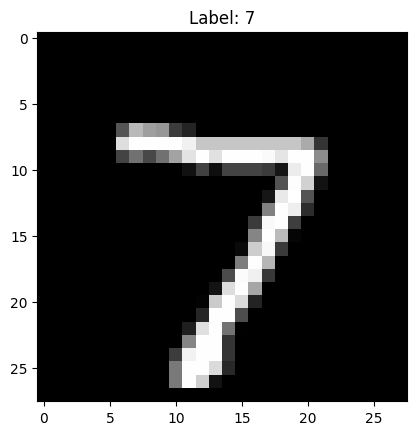

In [17]:
import matplotlib.pyplot as plt

predictions = model.predict(X_test) #คือการทำนายผลลัพธ์โดยใช้โมเดลที่ถูกฝึกสอนด้วยข้อมูลฝึกสอน เมื่อให้โมเดลรับข้อมูลทดสอบ

image = np.reshape(X_test[0], (28, 28)) #เพื่อทำการแปลงข้อมูลรูปภาพของตัวอย่างแรกใน X_test ให้อยู่ในรูปแบบของภาพที่มีขนาด 28x28 pixels

plt.imshow(image, cmap='gray') #สำหรับแสดงรูปภาพที่ได้จากข้อมูล image โดยใช้คำสั่ง imshow โดยกำหนด cmap='gray' เพื่อให้แสดงผลเป็นสีเทา
plt.title(f"Label: {predictions[0]}") #สำหรับแสดงรูปภาพที่ได้จากข้อมูล image โดยใช้คำสั่ง imshow โดยกำหนด cmap='gray' เพื่อให้แสดงผลเป็นสีเทา
plt.show() #ใช้สำหรับแสดงกราฟที่ถูกสร้างขึ้นด้วยคำสั่งก่อนหน้านี้
